# Checking GPU

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# Common cell for all Questions
#### Downloading and extracting data, importing packages, defining data paths, building character vocab, defining funciton for preprocessing data

## Downloading  and extracting data

In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
import tarfile

tar = tarfile.open('dakshina_dataset_v1.0.tar', "r:")
tar.extractall()
tar.close()

## Importing packages

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for visualisations
from IPython.display import HTML 
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

!pip install wandb
import wandb
from wandb.keras import WandbCallback

## Defining data paths

In [ ]:
train_data_path = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_data_path = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_data_path = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

## Building character vocab and defining funciton for preprocessing data

In [ ]:
# build character vocab
def build_character_vocab():
    
    # Vectorize the train data and val data.
    input_texts = []
    target_texts = []
    input_characters = set()
    target_characters = set()
    
    with open(train_data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    lines = [line for line in lines if '\t' in line]

    for line in lines:
        target_text, input_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character for the targets
        target_text = "\t" + target_text
        input_texts.append(input_text)
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

    # adding space character to the input and target character set
    input_characters.add(' ')
    target_characters.add(' ')

    input_characters = sorted(list(input_characters))
    target_characters = sorted(list(target_characters))
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

    print("Number of samples:", len(input_texts))
    print("Number of unique input tokens:", num_encoder_tokens)
    print("Number of unique output tokens:", num_decoder_tokens)
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

    return (num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)

In [ ]:
# preprocess the data
def data_preprocessing(data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length):
    
    # Vectorize the train data and val data.
    input_texts = []
    target_texts = []
    
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    lines = [line for line in lines if '\t' in line]
    # random.shuffle(lines)
    
    for line in lines:
        target_text, input_text, _ = line.split("\t")
        
        # We use "tab" as the "start sequence" character for the targets.
        target_text = "\t" + target_text
        input_texts.append(input_text)
        target_texts.append(target_text)    

    
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length), dtype="int32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length), dtype="int32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

        for t, char in enumerate(input_text):
            if char in input_token_index.keys():
                encoder_input_data[i, t] = input_token_index[char]
        encoder_input_data[i, t + 1 :] = input_token_index[' ']

        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            if char in target_token_index.keys():
                decoder_input_data[i, t] = target_token_index[char]
                if t > 0:
                    # decoder_target_data will be ahead by one timestep and will not include the start character.
                    decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_input_data[i, t + 1 :] = target_token_index[' ']
        decoder_target_data[i, t:, target_token_index[' ']] = 1.0
    
    return (encoder_input_data, decoder_input_data, decoder_target_data)


# Common cell for Questions [1,2,3,4] 
#### Defining function for calculating accuracy with greedy search and buiding inference model

## Calculate accuracy

In [ ]:
def cal_acc(encoder_inference_model, decoder_inference_model, encoder_input_data, decoder_input_data, decoder_layer):
    
    # decoder_output_data will be ahead by one timestep and will not include the start character.
    decoder_output_data =  decoder_input_data[:, 1:]

    # Encode the input as state vectors.
    states_value = encoder_inference_model.predict(encoder_input_data)
    
    # creating list for intial input states for multiple layers
    if type(states_value) != list:
        states_value = [states_value]
    states_value_input_list = states_value * decoder_layer
    
    # taking intial character for every examples
    target_input_seq = np.expand_dims(decoder_input_data[:,0], 1)
    
    # Sampling loop for a batch of sequences
    stop_condition = False
    i = 0

    # defining prediction array
    predictions = np.zeros( decoder_output_data.shape , dtype="int32" ) 

    while not stop_condition:
        output_tokens, states_value_output_list = decoder_inference_model.predict( [target_input_seq] + states_value_input_list)
        
        # Sample a token
        sampled_token_index = np.argmax( output_tokens, axis = 2 )

        # storing predicted characters
        predictions[:, i] = np.squeeze( sampled_token_index, axis = 1)

        # Exit condition: either hit max length or find stop character.
        if i == (max_decoder_seq_length-2):
            stop_condition = True
            break

        # Update the target sequence (of length 1).
        target_input_seq = sampled_token_index

        # Update states
        states_value_input_list = states_value_output_list
        
        i+=1
   
    # comparing original outputs with predicitons
    accuracy = np.sum(np.all(np.equal(predictions, decoder_output_data), axis=1)) / (decoder_output_data.shape[0])
    
    return accuracy

## Builiding inference model

In [ ]:
def build_encoder_inference_model(model, encoder_layer, cell_type):

    if cell_type == "LSTM":
        
        # defining encoder inference model
        encoder_inputs = model.input[0]
        encoder_outputs, state_h_enc, state_c_enc = model.get_layer("encoder_layer_"+str(encoder_layer)).output
        encoder_states = [state_h_enc, state_c_enc]

        encoder_inference_model = keras.Model(encoder_inputs, encoder_states)

        plot_model(encoder_inference_model, to_file='encoder_inference_model.png', show_shapes=True)

    elif cell_type == "GRU" or cell_type == "RNN":

        # defining encoder inference model
        encoder_inputs = model.input[0]
        encoder_outputs, state_c_enc = model.get_layer("encoder_layer_"+str(encoder_layer)).output
        encoder_states = [state_c_enc,]

        encoder_inference_model = keras.Model(encoder_inputs, encoder_states)

        plot_model(encoder_inference_model, to_file='encoder_inference_model.png', show_shapes=True)

    return encoder_inference_model

In [ ]:
def build_decoder_inference_model(model, decoder_layer, cell_type, latent_dim):

    if cell_type == "LSTM":

        # defining decoder inference model
        decoder_state_input_list = []
        for i in range(decoder_layer):
            decoder_state_input_list.append(keras.Input(shape=(latent_dim,)) )
            decoder_state_input_list.append(keras.Input(shape=(latent_dim,)) )

        decoder_state_output_list = []

        decoder_inputs = model.input[1]
        decoder_character_embedding_layer = model.get_layer('decoder_emb_layer')
        decoder_character_embeddings = decoder_character_embedding_layer(decoder_inputs)

        # index of layer in decoder_state_input_list
        h = 0
        c = 1

        # hidden layers
        decoder_layer_obj = model.get_layer('decoder_layer_1')
        decoder_outputs, state_h_dec, state_c_dec = decoder_layer_obj(decoder_character_embeddings, initial_state = [decoder_state_input_list[h],decoder_state_input_list[c]] )
        decoder_state_output_list.append( state_h_dec)
        decoder_state_output_list.append( state_c_dec)

        h += 2
        c += 2
        for i in range((decoder_layer)-1):
            decoder_layer_obj = model.get_layer('decoder_layer_'+str(i+2))
            decoder_outputs, state_h_dec, state_c_dec = decoder_layer_obj(decoder_outputs, initial_state = [decoder_state_input_list[h],decoder_state_input_list[c]])
            decoder_state_output_list.append( state_h_dec)
            decoder_state_output_list.append( state_c_dec)  
            h += 2
            c += 2

        # output layer
        decoder_dense = model.get_layer('decoder_output_layer')
        decoder_outputs = decoder_dense(decoder_outputs)

        decoder_inference_model = keras.Model([decoder_inputs] + decoder_state_input_list, [decoder_outputs] + [decoder_state_output_list] )

        plot_model(decoder_inference_model, to_file='decoder_inference_model.png', show_shapes=True)

    elif cell_type == "RNN" or cell_type == "GRU":

        # defining decoder inference model
        decoder_state_input_list = []
        for i in range(decoder_layer):
            decoder_state_input_list.append(keras.Input(shape=(latent_dim,)) )

        decoder_state_output_list = []

        decoder_inputs = model.input[1]
        decoder_character_embedding_layer = model.get_layer('decoder_emb_layer')
        decoder_character_embeddings = decoder_character_embedding_layer(decoder_inputs)

        # index of layer in decoder_state_input_list
        c = 0

        # hidden layers
        decoder_layer_obj = model.get_layer('decoder_layer_1')
        decoder_outputs, state_c_dec = decoder_layer_obj(decoder_character_embeddings, initial_state = [decoder_state_input_list[c]] )
        decoder_state_output_list.append( state_c_dec)

        c += 1
        for i in range((decoder_layer)-1):
            decoder_layer_obj = model.get_layer('decoder_layer_'+str(i+2))
            decoder_outputs, state_c_dec = decoder_layer_obj(decoder_outputs, initial_state = [decoder_state_input_list[c]])
            decoder_state_output_list.append( state_c_dec)  
            c += 1

        # output layer
        decoder_dense = model.get_layer('decoder_output_layer')
        decoder_outputs = decoder_dense(decoder_outputs)

        decoder_inference_model = keras.Model([decoder_inputs] + decoder_state_input_list, [decoder_outputs] + [decoder_state_output_list] )

        plot_model(decoder_inference_model, to_file='decoder_inference_model.png', show_shapes=True) 
    return decoder_inference_model

# Question 1 
### Build the train model with flexible parameters

In [ ]:
def build_model(num_encoder_tokens, num_decoder_tokens, input_embedding_size, latent_dim, dropout, encoder_layer, decoder_layer, cell_type, max_encoder_seq_length, max_decoder_seq_length):
    
    if cell_type == "LSTM":
        
        # intializing encoder 
        # Defining input character embedding layer
        encoder_inputs = keras.Input(shape=(None,), name = "encoder_input_layer")
        encoder_character_embedding_layer = tf.keras.layers.Embedding( num_encoder_tokens, input_embedding_size, name = "encoder_emb_layer" )
        encoder_character_embeddings = encoder_character_embedding_layer(encoder_inputs)
            
        # Defining first encoder layer
        encoder = keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, dropout = dropout, name = "encoder_layer_1")
        encoder_outputs, state_h, state_c = encoder(encoder_character_embeddings)

        # stacking more encoder layers
        for i in range(encoder_layer-1):
            encoder = keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, dropout = dropout, name = "encoder_layer_"+str(i+2))
            encoder_outputs, state_h, state_c = encoder(encoder_outputs)

        # We discard 'encoder_outputs' and only keep the states.
        encoder_states = [state_h, state_c]

        # intializing decoder
        # Defining decoder chracter embedding layer
        decoder_inputs = keras.Input(shape=(None,), name = "decoder_input_layer")
        decoder_character_embedding_layer = tf.keras.layers.Embedding( num_decoder_tokens, input_embedding_size, name = "decoder_emb_layer")
        decoder_character_embeddings = decoder_character_embedding_layer(decoder_inputs)
        
        # Set up the decoder, using 'encoder_states' as initial state.
        # intilaizing first decoder layer
        decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout = dropout, name = "decoder_layer_1")
        decoder_outputs, _, _ = decoder_lstm(decoder_character_embeddings, initial_state = encoder_states)
        
        # stacking more decoder layers
        for i in range(decoder_layer-1):
            decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout = dropout, name = "decoder_layer_"+str(i+2))
            decoder_outputs, _, _ = decoder_lstm(decoder_outputs, initial_state = encoder_states)
        
        # output layer
        decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name = "decoder_output_layer")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    elif cell_type == "GRU":
        
        # intializing encoder 
        # Defining input character embedding layer
        encoder_inputs = keras.Input(shape=(None,), name = "encoder_input_layer")
        encoder_character_embedding_layer = tf.keras.layers.Embedding( num_encoder_tokens, input_embedding_size , name = "encoder_emb_layer")
        encoder_character_embeddings = encoder_character_embedding_layer(encoder_inputs)
            
        # Defining first encoder layer
        encoder = keras.layers.GRU(latent_dim, return_state=True, return_sequences=True, dropout = dropout, name = "encoder_layer_1" )
        encoder_outputs, state_c = encoder(encoder_character_embeddings)

        # stacking more encoder layers
        for i in range(encoder_layer-1):
            encoder = keras.layers.GRU(latent_dim, return_state=True, return_sequences=True, dropout = dropout, name = "encoder_layer_"+str(i+2) )
            encoder_outputs, state_c = encoder(encoder_outputs)

        # We discard 'encoder_outputs' and only keep the states.
        encoder_states = [state_c]

        # intializing decoder
        # Defining decoder chracter embedding layer
        decoder_inputs = keras.Input(shape=(None,), name = "decoder_input_layer")
        decoder_character_embedding_layer = tf.keras.layers.Embedding( num_decoder_tokens, input_embedding_size, name = "decoder_emb_layer")
        decoder_character_embeddings = decoder_character_embedding_layer(decoder_inputs)
        
        # Set up the decoder, using 'encoder_states' as initial state.
        # intilaizing first decoder layer
        decoder_gru = keras.layers.GRU(latent_dim, return_sequences=True, return_state=True, dropout = dropout, name = "decoder_layer_1")
        decoder_outputs, _ = decoder_gru(decoder_character_embeddings, initial_state = encoder_states)
        
        # stacking more decoder layers
        for i in range(decoder_layer-1):
            decoder_gru = keras.layers.GRU(latent_dim, return_sequences=True, return_state=True, dropout = dropout, name = "decoder_layer_"+str(i+2))
            decoder_outputs, _ = decoder_gru(decoder_outputs, initial_state = encoder_states)
        
        # output layer
        decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name = "decoder_output_layer")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    elif cell_type == "RNN":
        
        # intializing encoder 
        # Defining input character embedding layer
        encoder_inputs = keras.Input(shape=(max_encoder_seq_length,), name = "encoder_input_layer")
        encoder_character_embedding_layer = tf.keras.layers.Embedding( num_encoder_tokens, input_embedding_size, input_length = max_encoder_seq_length , name = "encoder_emb_layer")
        encoder_character_embeddings = encoder_character_embedding_layer(encoder_inputs)
            
        # Defining first encoder layer
        encoder = keras.layers.SimpleRNN(latent_dim, return_state=True, return_sequences=True, dropout = dropout, unroll = True, name = "encoder_layer_1")
        encoder_outputs, state_c = encoder(encoder_character_embeddings)

        # stacking more encoder layers
        for i in range(encoder_layer-1):
            encoder = keras.layers.SimpleRNN(latent_dim, return_state=True, return_sequences=True, dropout = dropout, unroll = True, name = "encoder_layer_"+str(i+2))
            encoder_outputs, state_c = encoder(encoder_outputs)

        # We discard 'encoder_outputs' and only keep the states.
        encoder_states = [state_c]

        # intializing decoder
        # Defining decoder chracter embedding layer
        decoder_inputs = keras.Input(shape=(max_decoder_seq_length,), name = "decoder_input_layer")
        decoder_character_embedding_layer = tf.keras.layers.Embedding( num_decoder_tokens, input_embedding_size, input_length = max_decoder_seq_length , name = "decoder_emb_layer")
        decoder_character_embeddings = decoder_character_embedding_layer(decoder_inputs)
        
        # Set up the decoder, using 'encoder_states' as initial state.
        # intilaizing first decoder layer
        decoder_simplernn = keras.layers.SimpleRNN(latent_dim, return_sequences=True, return_state=True, dropout = dropout, unroll = True, name = "decoder_layer_1")
        decoder_outputs, _ = decoder_simplernn(decoder_character_embeddings, initial_state = encoder_states)
        
        # stacking more decoder layers
        for i in range(decoder_layer-1):
            decoder_simplernn = keras.layers.SimpleRNN(latent_dim, return_sequences=True, return_state=True, dropout = dropout, unroll = True, name = "decoder_layer_"+str(i+2))
            decoder_outputs, _ = decoder_simplernn(decoder_outputs, initial_state = encoder_states)
        
        # output layer lstm
        decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name = "decoder_output_layer")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
        
        
    return model

# Question 2
### Train model with sweep config

In [ ]:
!wandb login

In [ ]:
batch_size = 64  
epochs = 25

In [ ]:
# building common character dictionary for train and val data
num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length = build_character_vocab()

# data preprocessing, creating encoder data and decoder data from text
train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = data_preprocessing(train_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = data_preprocessing(val_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)


In [ ]:
# sweep config
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_acc',
        'goal' : 'maximize'
    },
    'parameters' : {
        'input_embedding_size' : {
            'values' : [16, 32, 64, 128, 256]
        },
        'encoder_layer' : {
            'values' : [1, 2, 3]
        },
        'decoder_layer' : {
            'values' : [1, 2, 3]
        },
        'latent_dim' : {
            'values' : [16, 32, 64, 128, 256, 512]
        },
        'cell_type' : {
            'values' : ['RNN', 'GRU', 'LSTM']
        },
        'dropout' : {
            'values' : [0.2, 0.3, 0.5, 0.7]
        }
    }
}

In [ ]:
def train():
    config_defaults = {
        'input_embedding_size' : 32,
        'encoder_layer': 1,
        'decoder_layer' : 1,
        'latent_dim' : 256,
        'cell_type' : 'LSTM',
        'dropout' : 0.2,
    }

    # wandb intialization
    wandb.init(config = config_defaults, project = "DL_assignment_3" )
    config = wandb.config
    
    # setting run name
    exp_name = "emb_size" + str(config.input_embedding_size) + "_lt_dim_"+ str(config.latent_dim) +  "_cell_" + str(config.cell_type) + "_enc_la_" + str(config.encoder_layer) + "_dec_la_" + str(config.decoder_layer) + "_drp_" + str(config.dropout)
    wandb.run.name = exp_name
    
    # building model
    model = build_model(
        num_encoder_tokens, num_decoder_tokens, config.input_embedding_size, config.latent_dim, config.dropout, 
        config.encoder_layer, config.decoder_layer, config.cell_type, max_encoder_seq_length, max_decoder_seq_length
    )

    # compiling model
    model.compile(
        optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    callbacks = [
        EarlyStopping(monitor = 'val_loss', patience = 5, verbose=1),
        WandbCallback()
    ]

    model.fit(
        [train_encoder_input_data, train_decoder_input_data],train_decoder_target_data,
        batch_size = batch_size,
        epochs = epochs,
        callbacks = callbacks,
        validation_data = ([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data),
        verbose = 1
    )
    
    # intializing inference model
    encoder_inference_model = build_encoder_inference_model(model, config.encoder_layer, config.cell_type)
    decoder_inference_model = build_decoder_inference_model(model, config.decoder_layer, config.cell_type, config.latent_dim)
    
    # calculating validation accuracy
    val_acc = cal_acc(encoder_inference_model, decoder_inference_model, val_encoder_input_data, val_decoder_input_data, config.decoder_layer)
    
    wandb.log({'val_acc':val_acc})


In [ ]:
sweep_id = wandb.sweep(sweep_config,  entity = "cs20s002", project = "DL_assignment_3")
wandb.agent('pfjck0e8', train, count = 101)

# Question 4 
### Retraining model with best hyperparamters and defining inference model 

## Retraining model with best hyperparamters

In [ ]:
batch_size = 64  
epochs = 20

# building common character dictionary for train and val data
num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length = build_character_vocab()

# data preprocessing, creating encoder data and decoder data from text
train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = data_preprocessing(train_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = data_preprocessing(val_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)


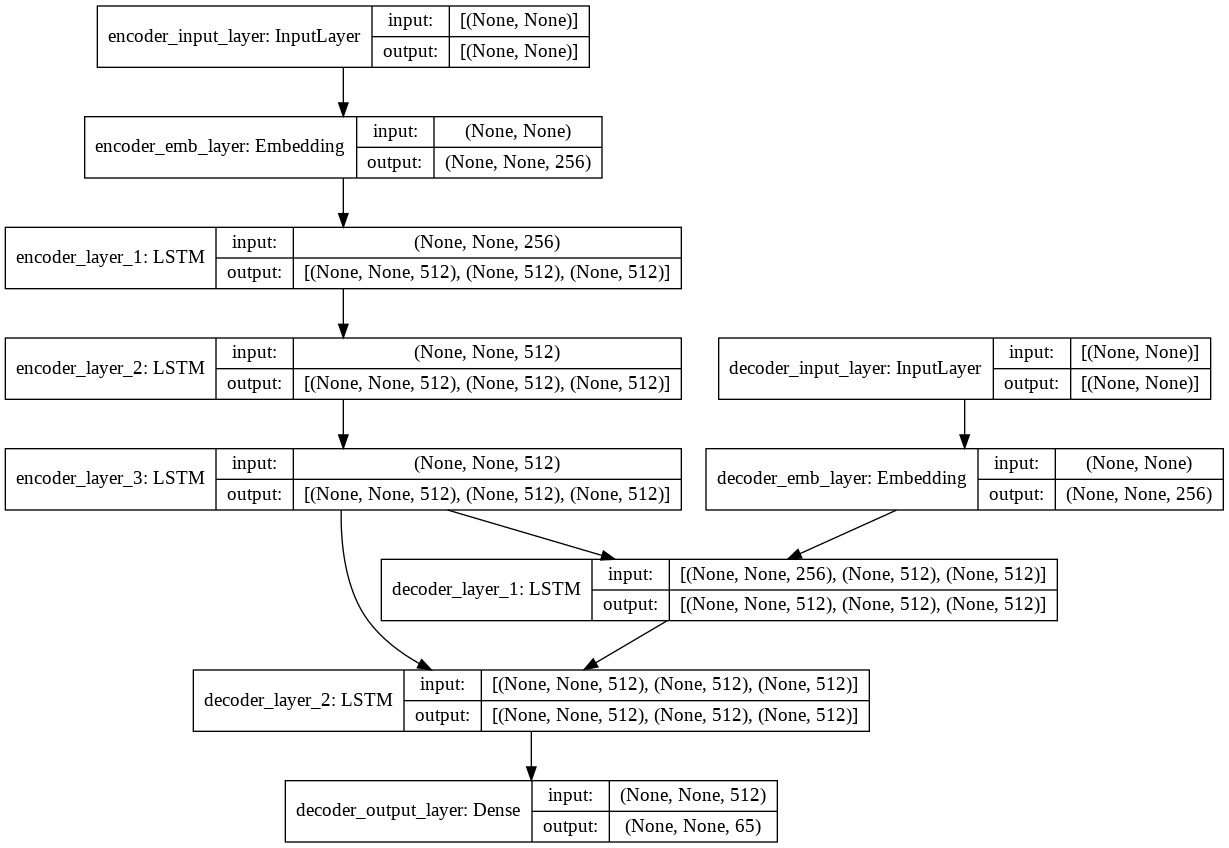

In [ ]:
input_embedding_size = 256
encoder_layer= 3
decoder_layer = 2
latent_dim = 512
cell_type = "LSTM"
dropout = 0.5

# building model
model = build_model( num_encoder_tokens, num_decoder_tokens, input_embedding_size, latent_dim, dropout, encoder_layer, decoder_layer, cell_type, max_encoder_seq_length, max_decoder_seq_length)

# compiling model
model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3, verbose=1)
]

plot_model(model, to_file='model.png', show_shapes=True)

    

In [ ]:
model.fit(
    [train_encoder_input_data, train_decoder_input_data],train_decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = ([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data),
    verbose = 1
)

## Defining inference model 

### Encoder inference model

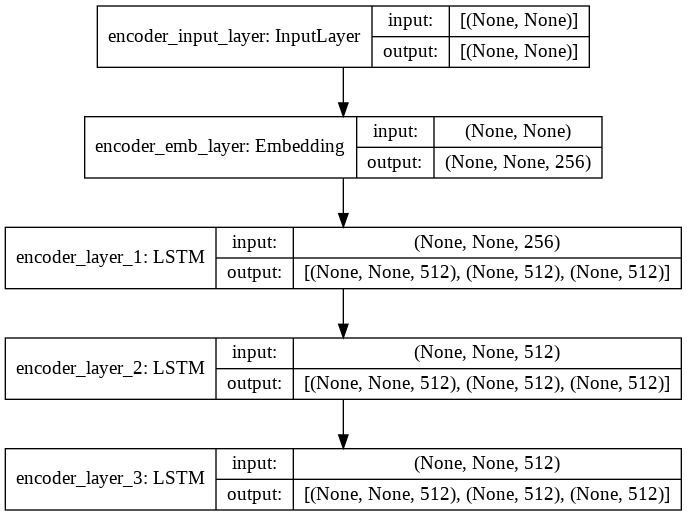

In [ ]:
encoder_inference_model = build_encoder_inference_model(model, encoder_layer, cell_type)

plot_model(encoder_inference_model, to_file='encoder_inference_model.png', show_shapes=True)

### Decoder inference model

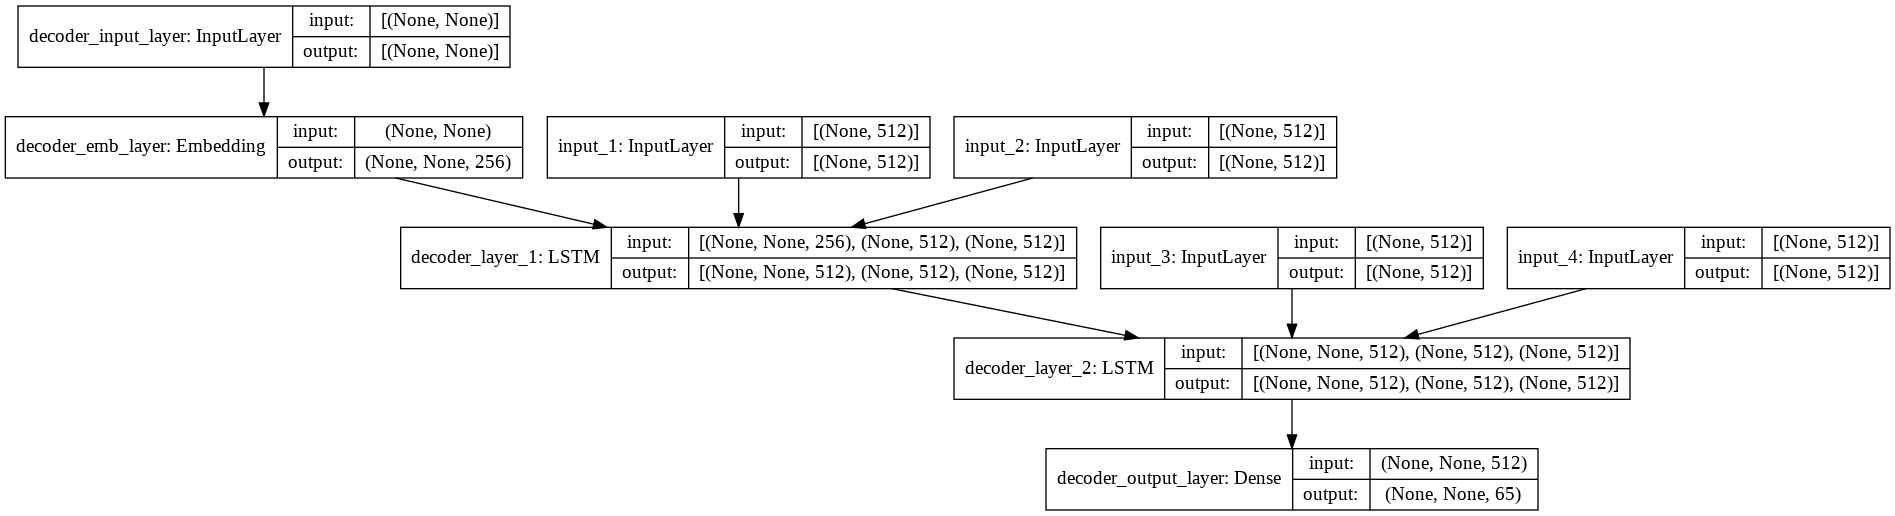

In [ ]:
decoder_inference_model = build_decoder_inference_model(model, decoder_layer, cell_type, latent_dim)

plot_model(decoder_inference_model, to_file='decoder_inference_model.png', show_shapes=True)

### Word wise validation accuracy

In [ ]:
val_acc = cal_acc(encoder_inference_model, decoder_inference_model, val_encoder_input_data, val_decoder_input_data, decoder_layer)
print('Word level validation accuracy : ', val_acc)

### Test data

In [ ]:
# data preprocessing, creating encoder data and decoder data from text
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = data_preprocessing(test_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

### Question 4(a) (Measuring test accuracy with best model)

In [ ]:
test_acc = cal_acc(encoder_inference_model, decoder_inference_model, test_encoder_input_data, test_decoder_input_data, decoder_layer)
print('test_acc : ', test_acc)

### Question 4(b) (Creating csv file for all predictions)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_inference_model.predict(input_seq)
    
    states_value_input_list = []
    for i in range(decoder_layer):
        states_value_input_list.append(states_value[0])
        states_value_input_list.append(states_value[1])
   
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1), dtype="int32")
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        output_tokens, states_value_output_list = decoder_inference_model.predict( [target_seq] + states_value_input_list)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]

        # Exit condition: either hit max length or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
            break
        
        decoded_sentence += sampled_char

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1), dtype="int32")
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value_input_list = states_value_output_list
    return decoded_sentence

In [ ]:
# Generate 10 random numbers between 0 and test sample size
randomlist = random.sample(range( 0, len(test_encoder_input_data)-1 ), 64)
sample_test_input_data = test_encoder_input_data[randomlist]
sample_test_output_data = test_decoder_input_data[randomlist][:,1:]

results = []
match_list = []
for i in range(len(sample_test_input_data)):
    
    match = 0

    input_seq = sample_test_input_data[i].reshape(1,-1)
    prediction = decode_sequence(input_seq)

    output_text = ""
    for j in sample_test_output_data[i]:
        char = reverse_target_char_index[j]
        output_text += char

    if output_text == prediction[:-2]:
        match = 1

    input_text = ""
    for j in sample_test_input_data[i]:
        char = reverse_input_char_index[j]
        if not (char=="\n" or char=="\t" or char==" "):
            input_text += char
    
    for s in range(len(prediction)):
        char = prediction[s]
        if char=="\n" or char=="\t" or char==" ":
            break
    
    prediction = prediction[:s]


    
    match_list.append(match)
    results.append( input_text + "\n" + prediction )


data = np.array(match_list).reshape(8,8)
labels = np.array(results).reshape(8,8)

fig, ax = plt.subplots(figsize=(16, 16))

fontdict = {'fontsize': 20}
# point to the font location with an absolute path

nim = '/content/Nirmala.ttf'
# configure the Hindi font

hindi_font = FontProperties(fname = nim, size = 16)
ax = sns.heatmap(data, annot = labels, fmt = '', cmap='Blues', annot_kws = { 'fontproperties' : hindi_font}, vmin=0, vmax=1)
ax.set_title("Predictions with input strings block colored blue if matched with expected output and white otherwise", fontsize = 20)



In [ ]:
# # Wandb config 

# # Intialize a new run
# wandb.init(project="DL_assignment_3", name="Question_4b_prediction")

# # Log the image
# wandb.log({"Question_4b_prediction": [ wandb.Image( fig, caption = "Predictions with input strings block colored blue if matched with expected output and white otherwise "  )   ]})
# # wandb.log({"Confusion_matrix": plt})

# wandb.finish()

In [ ]:
# saving all predictions in text file in format: number   input_text    expected_output_text   predicted_output_text   match(y/n)

title = ['number','input_text','expected_output_text','predicted_output_text','match(1/0)']
rows = []


for (i, enc_seq, dec_seq) in zip(range(len(test_encoder_input_data)), test_encoder_input_data,test_decoder_input_data):

    match = 0
    
    encoder_input_text = ""
    for char_index in enc_seq:
        char = reverse_input_char_index[char_index]
        if not (char=="\n" or char=="\t" or char==" "):
            encoder_input_text +=  char
            
    input_encoder_seq = enc_seq.reshape(1,-1)
    
    prediction = decode_sequence(input_encoder_seq)
    
    dec_input_text = ""
    for char_index in dec_seq:
        char = reverse_target_char_index[char_index]
        if not (char=="\n" or char=="\t" or char==" "):
            dec_input_text +=  char
    
    for s in range(len(prediction)):
        char = prediction[s]
        if char=="\n" or char=="\t" or char==" ":
            break
    prediction = prediction[:s]

    if dec_input_text == prediction:
        match = 1

    rows.append( [ str(i+1), encoder_input_text, dec_input_text, prediction, str(match) ] )
    print(str(i+1) + "   " + encoder_input_text + "   " + dec_input_text + "   " + prediction + "   " + str(match))

import csv
# name of csv file 
filename = "prediction_file.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(title) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

### Beam search

In [ ]:
# beam search with one example
from math import log
from numpy import array
from numpy import argmax

def beam_search(encoder_inference_model, decoder_inference_model, encoder_input_data, decoder_input_data, decoder_layer, k):
    match_count = 0
    for example in range(len(encoder_input_data)):

        string = ""
        for i in encoder_input_data[example]:
            string+= reverse_input_char_index[i]
        print(string)

        # Encode the input as state vectors.
        states_value = encoder_inference_model.predict(encoder_input_data[example].reshape(1,-1))


        # creating list for intial input states for multiple layers
        if type(states_value) != list:
            states_value = [states_value]
        states_value_input_list = states_value * decoder_layer

        # intializing sequences
        sequences = [ [ [target_token_index['\t']], 0.0,  states_value_input_list] ]

        for _ in range(max_decoder_seq_length):
            all_candidates = list()
            
            # expand each current candidate
            for i in range(len(sequences)):
                seq, score, state_input_list = sequences[i]

                # extarcting the last predicted character from sequence of string
                input_seq = np.expand_dims(seq[-1], axis = 0)
                
                output_tokens, states_value_output_list = decoder_inference_model.predict( [input_seq] + state_input_list )
                
                # sorting vocab predictions
                top_k_elements = output_tokens.argsort(axis = 2)[:,:,-k:][:,:,::-1]
                
                # storing top k most probable seq in all_candidates per each seq in sequences list
                for j in range(k):
                    candidate = [seq + [ np.squeeze(top_k_elements)[j] ], score - log( output_tokens[ 0, 0, np.squeeze(top_k_elements)[j] ] ), states_value_output_list ]
                    all_candidates.append(candidate)

            # order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:tup[1])
            
            # select k best seq and storing in sequences for next iteration
            sequences = ordered[:k]
        
        # measuring validation accuracy if any one of k predicted seq match to original seq
        match = 0
        # for seq in sequences:
            
        if np.all(np.equal(sequences[0][0][:-1], decoder_input_data[example])):
            match = 1

        string = ""
        for i in sequences[0][0][1:]:
            string += reverse_target_char_index[i]
        print(string)
        
        if match == 1:
            match_count += 1
    
    return match_count/len(encoder_input_data)


#### Measuring test accuracy with Beam search with different beam width

In [ ]:
beam_width_list = [3]
# wandb.init(project="DL_assignment_3", name="beam_search")
for k in beam_width_list:
    test_acc_beam_search = beam_search(encoder_inference_model, decoder_inference_model, val_encoder_input_data, val_decoder_input_data, decoder_layer, k)
    print("test accuracy with beam search with beam width : {} is {}.".format(k,test_acc_beam_search))
    # wandb.log({'test_acc_with_beam_width_'+str(k) : test_acc_beam_search})
# wandb.finish()

# Common cell for Question [5, 6]
#### Building Attention model, defining function for caculating accuracy for attention model, loss funciton, optimizer

## Attention model 

In [ ]:
# building Attention model
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout, cell_type, encoder_layers):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.encoder_layers = encoder_layers
        self.encoder_layer_list = []
        
        for i in range(self.encoder_layers):
            if cell_type == "GRU":
                layer_cell = tf.keras.layers.GRU(self.enc_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform', 
                                        dropout = dropout)

            elif cell_type == "LSTM":
                layer_cell = tf.keras.layers.LSTM(self.enc_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform', 
                                        dropout = dropout)
            
            self.encoder_layer_list.append(layer_cell)

    def call(self, x, cell_type):
        x = self.embedding(x)
    
        for encoder_layer in self.encoder_layer_list:
            if cell_type == "GRU":
                x, state = encoder_layer(x)
                enc_state_list = [state]

            elif cell_type == "LSTM":
                x, state, state_c = encoder_layer(x)
                enc_state_list = [state, state_c]

        return x, enc_state_list


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V( tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)) )

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout, cell_type, decoder_layers):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.decoder_layers = decoder_layers
        
        self.decoder_layer_list = []
        
        for i in range(decoder_layers):

            if cell_type == "GRU":
                layer_cell = tf.keras.layers.GRU(self.dec_units,
                                            return_sequences=True,
                                            return_state=True,
                                            recurrent_initializer='glorot_uniform',
                                            dropout = dropout)
            elif  cell_type == "LSTM":
                layer_cell = tf.keras.layers.LSTM(self.dec_units,
                                            return_sequences=True,
                                            return_state=True,
                                            recurrent_initializer='glorot_uniform',
                                            dropout = dropout)
            self.decoder_layer_list.append(layer_cell)

        self.fc = tf.keras.layers.Dense(vocab_size)


        self.attention_layer_list = []
        
        for i in range(decoder_layers):
            
            # used for attention
            attention_layer = BahdanauAttention(self.dec_units)
            
            self.attention_layer_list.append(attention_layer)

    def call(self, x, hidden, enc_output, cell_type):
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        dec_out_state_list = []
        
        attention_weights_list = []

        for i in range(self.decoder_layers):

            # enc_output shape == (batch_size, max_length, hidden_size)
            context_vector, attention_weights = self.attention_layer_list[i]( hidden[i][0], enc_output )

            attention_weights_list.append(attention_weights)

            # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)


            # passing the concatenated vector to the GRU
            if cell_type == "GRU":
                x, state = self.decoder_layer_list[i](x, initial_state = hidden[i] )
                dec_out_state_list.append([state,])
            
            elif cell_type == "LSTM":
                x, state, state_c = self.decoder_layer_list[i](x, initial_state = hidden[i] )
                dec_out_state_list.append([state, state_c])
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, dec_out_state_list, attention_weights_list


## Defining loss funciton and optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Funciton for calculating accuracy for attention model

In [ ]:
def cal_acc_attention(encoder, decoder, encoder_input_data, decoder_input_data, latent_dim, cell_type, decoder_layers):
    
    decoder_output_data =  decoder_input_data[:, 1:]

    encoder_input_data = tf.convert_to_tensor(encoder_input_data)

    enc_out, enc_hidden = encoder(encoder_input_data, cell_type)
    
    dec_hidden = [enc_hidden]*decoder_layers
    
    dec_input = tf.expand_dims(decoder_input_data[:,0], 1)
    
    # defining prediction array
    prediction_array = np.zeros( decoder_output_data.shape , dtype="int32" ) 

    for t in range(max_decoder_seq_length-1):

        predictions, dec_hidden, attention_weights_list = decoder(dec_input, dec_hidden, enc_out, cell_type)

        predicted_ids = tf.argmax(predictions, axis = 1)
        

        prediction_array[:, t] = tf.make_ndarray(tf.make_tensor_proto(predicted_ids) )

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims(predicted_ids,1)
   
    # comparing original outputs with predicitons
    accuracy = np.sum(np.all(np.equal(prediction_array, decoder_output_data), axis=1)) / (decoder_output_data.shape[0])
    
    return accuracy

# Question 5

## Loading dataset

In [ ]:
batch_size = 64  
epochs = 15

# building common character dictionary for train and val data
num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length = build_character_vocab()

# defining dict for reverse index to char mapping
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

# data preprocessing, creating encoder data and decoder data from text
train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = data_preprocessing(train_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = data_preprocessing(val_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)

BUFFER_SIZE = len(train_encoder_input_data)
steps_per_epoch = len(train_encoder_input_data)//batch_size

dataset = tf.data.Dataset.from_tensor_slices((train_encoder_input_data, train_decoder_input_data)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(batch_size, drop_remainder=True)

## Question 5 (a)
### Training Attention model with sweep config

In [ ]:
# sweep config
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'input_embedding_size' : {
            'values' : [32, 64, 128, 256]
        },
        'encoder_layers' : {
            'values' : [1, 2, 3]
        },
        'decoder_layers' : {
            'values' : [1, 2, 3]
        },
        'latent_dim' : {
            'values' : [64, 128, 256, 512]
        },
        'cell_type' : {
            'values' : ['GRU', 'LSTM']
        },
        'dropout' : {
            'values' : [0.2, 0.3, 0.5, 0.7]
        }
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 12,
    }
}

In [ ]:
def train():
    config_defaults = {
        'input_embedding_size' : 32,
        'encoder_layers' : 2,
        'decoder_layers': 2,
        'latent_dim' : 256,
        'cell_type' : 'LSTM',
        'dropout' : 0.2
    }

    # wandb intialization
    wandb.init(config = config_defaults, project = "DL_assignment_3" )
    config = wandb.config
    
    # setting run name
    exp_name = "emb_size" + str(config.input_embedding_size) + "_lt_dim_"+ str(config.latent_dim) +  "_cell_" + str(config.cell_type) + "_drp_" + str(config.dropout) + "_enc_" + str(config.encoder_layers) + "_dec_" + str(config.decoder_layers)
    wandb.run.name = exp_name

    # intializing encoder 
    # encoder_inputs = keras.Input(shape=(None,), name = "encoder_input_layer")
    encoder = Encoder(num_encoder_tokens, config.input_embedding_size, config.latent_dim, batch_size, config.dropout, config.cell_type, config.encoder_layers)


    # intializing decoder
    # decoder_inputs = keras.Input(shape=(None,), name = "decoder_input_layer")
    decoder = Decoder(num_decoder_tokens, config.input_embedding_size, config.latent_dim, batch_size, config.dropout, config.cell_type, config.decoder_layers)

    
    @tf.function
    def train_step(inp, targ, cell):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, cell)

            dec_hidden = [enc_hidden]*(config.decoder_layers)

            dec_input = tf.expand_dims([target_token_index['\t']] * batch_size, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, cell)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

    for epoch in range(epochs):

        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, config.cell_type)
            total_loss += batch_loss

            if batch % 100 == 0:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

        print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
        wandb.log({'train_loss':total_loss/steps_per_epoch})

        val_acc = cal_acc_attention(encoder, decoder, val_encoder_input_data, val_decoder_input_data, config.latent_dim, config.cell_type, config.decoder_layers)

    # match = 0
    # for enc_inp_seq,dec_inp_seq in zip(val_encoder_input_data, val_decoder_input_data):
    #     dec_input_text = ""
    #     for char_index in dec_inp_seq:
    #         char = reverse_target_char_index[char_index]
    #         if not (char=="\n" or char=="\t" or char==" "):
    #             dec_input_text +=  char

    #     result = evaluate( enc_inp_seq.reshape(1,-1), encoder, decoder, config.latent_dim, config.cell_type)
    #     if result == dec_input_text:
    #         match += 1
        wandb.log({'val_accuracy' : val_acc})
        

In [ ]:
sweep_id = wandb.sweep(sweep_config,  entity = "cs20s002", project = "DL_assignment_3")
wandb.agent('2ezovvaf', train, count = 100)

## Question 5 (b,c,d)
### Attention Model with best hyperparameter and measuring test accuracy

In [ ]:
batch_size = 64  
epochs = 20
input_embedding_size =  128
latent_dim = 128
cell_type = 'LSTM'
dropout = 0.5
encoder_layers = 1
decoder_layers = 3

In [ ]:
# intializing encoder 
encoder = Encoder(num_encoder_tokens, input_embedding_size, latent_dim, batch_size, dropout, cell_type, encoder_layers)

# intializing decoder
decoder = Decoder(num_decoder_tokens, input_embedding_size, latent_dim, batch_size, dropout, cell_type, decoder_layers )


@tf.function
def train_step(inp, targ, cell):
    loss = 0

    with tf.GradientTape() as tape:

        enc_output, enc_hidden = encoder(inp, cell)

        dec_hidden = [enc_hidden]*decoder_layers

        dec_input = tf.expand_dims([target_token_index['\t']] * batch_size, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, cell)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


for epoch in range(epochs):

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, cell_type)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')


    val_acc = cal_acc_attention(encoder, decoder, val_encoder_input_data, val_decoder_input_data, latent_dim, cell_type, decoder_layers)
    print("val_acc",val_acc)
        

### b-part
#### Loading test data

In [ ]:
# data preprocessing, creating encoder data and decoder data from text
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = data_preprocessing(test_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)


In [ ]:
test_acc = cal_acc_attention(encoder, decoder, test_encoder_input_data, test_decoder_input_data, latent_dim, cell_type, decoder_layers)
print(test_acc)

#### Predicting result and for given input string and saving in csv file

In [ ]:
# to print the predicitons
def evaluate( encoder_input_data, encoder, decoder, latent_dim, cell_type, decoder_layers):
    
    encoder_input_data = tf.convert_to_tensor(encoder_input_data)
    
    result = ''

    enc_out, enc_hidden = encoder(encoder_input_data, cell_type)

    dec_hidden = [enc_hidden]*decoder_layers
    dec_input = tf.expand_dims([ target_token_index['\t'] ], 0)

    for t in range(max_decoder_seq_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, cell_type)
        
        predicted_id = tf.argmax(predictions[0]).numpy()


        if reverse_target_char_index[predicted_id] == '\n':
            return result

        result += reverse_target_char_index[predicted_id] + ''
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
# saving all predictions in text file in format: number   input_text    expected_output_text   predicted_output_text   match(y/n)

title = ['number','input_text','expected_output_text','predicted_output_text','match(1/0)']
rows = []


for (i, enc_seq, dec_seq) in zip(range(len(test_encoder_input_data)), test_encoder_input_data, test_decoder_input_data):

    match = 0
    
    encoder_input_text = ""
    for char_index in enc_seq:
        char = reverse_input_char_index[char_index]
        if not (char=="\n" or char=="\t" or char==" "):
            encoder_input_text +=  char
            
    dec_input_text = ""
    for char_index in dec_seq:
        char = reverse_target_char_index[char_index]
        if not (char=="\n" or char=="\t" or char==" "):
            dec_input_text +=  char

    result = evaluate( enc_seq.reshape(1,-1), encoder, decoder, latent_dim, cell_type, decoder_layers)
    

    for s in range(len(result)):
        char = result[s]
        if char=="\n" or char=="\t" or char==" ":
            break
    result = result[:s]

    if result == dec_input_text:
        match = 1


    rows.append( [ str(i), encoder_input_text, dec_input_text, result, str(match) ] )
    print(str(i) + "   " + encoder_input_text + "   " + dec_input_text + "   " + result + "   " + str(match))

import csv
# name of csv file 
filename = "prediction_attention_file.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(title) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

### c-part

In [ ]:
# saving all predictions in text file in format: number   input_text    expected_output_text   seq2seq_predicted_output_text    Attention_predicted_output_text  

title = ['number','input_text','expected_output_text','seq2seq_predicted_output_text','Attention_predicted_output_text']
csv_rows = []

import pandas as pd

seq2seq_model_pred = pd.read_csv('prediction_file.csv', sep=',',header=None).to_numpy()
attention_model_pred = pd.read_csv('prediction_attention_file.csv', sep=',',header=None).to_numpy()

rows = set(np.where(seq2seq_model_pred[:,4] == '0' )[0]).intersection(set(np.where(attention_model_pred[:,4] == '1')[0]))
rows = list(rows)
rows.sort()

csv_rows = []
for i in rows:

    print("====================================================================")
    print("Example ", i+1)
    print("Input : ",seq2seq_model_pred[i][1], "output should be : ", seq2seq_model_pred[i,2])
    print("Wrongly pridected output in seq2seq model : ", seq2seq_model_pred[i][3])
    print("Rightly pridected output in Attention model : ", attention_model_pred[i][3])
    print("====================================================================")
    csv_rows.append( [ str(i+1), seq2seq_model_pred[i][1], seq2seq_model_pred[i,2], seq2seq_model_pred[i][3], attention_model_pred[i][3] ] )

print(len(rows))

import csv
# name of csv file 
filename = "corrected_predictions_with_attention_file.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(title) 
        
    # writing the data rows 
    csvwriter.writerows(csv_rows)

### d-part
### Attention heatmaps

In [ ]:
def preprocess_input_word(input_text):
    encoder_input_data = np.zeros(
        (1, max_encoder_seq_length), dtype="int32"
    )

    for t, char in enumerate(input_text):
        if char in input_token_index.keys():
            encoder_input_data[0, t] = input_token_index[char]
    encoder_input_data[0, t + 1 :] = input_token_index[' ']
    return encoder_input_data

In [ ]:
def get_attention_weights(word):
    
    attention_matrices = np.zeros((decoder_layers, max_decoder_seq_length , max_encoder_seq_length))
    
    encoder_input_data = preprocess_input_word(word)

    encoder_input_data = tf.convert_to_tensor(encoder_input_data)
    
    result = ''

    enc_out, enc_hidden = encoder(encoder_input_data, cell_type)

    dec_hidden = [enc_hidden]*decoder_layers
    dec_input = tf.expand_dims([ target_token_index['\t'] ], 0)

    for t in range(max_decoder_seq_length):
        predictions, dec_hidden, attention_weights_list = decoder(dec_input, dec_hidden, enc_out, cell_type)

        # storing the attention weights to plot later on
        for a in range(len(attention_weights_list)):
            attention_weights = tf.reshape(attention_weights_list[a], (-1, ))
            attention_matrices[a][t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += reverse_target_char_index[predicted_id] + ''

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, encoder_input_data, attention_matrices

In [ ]:
def attention_heatmaps(word):
    result, input_seq, attention_matrices = get_attention_weights(word)
    
    input_string_with_spaces = ""
    
    for i in input_seq[0]:
        input_string_with_spaces += reverse_input_char_index[i.numpy()]
    
    return result, input_string_with_spaces, attention_matrices

In [ ]:
# Generate 10 random numbers between 0 and test sample size
randomlist = random.sample(range( 0, len(test_encoder_input_data)-1 ), 12)
attention_matrices_list=[]

sample_test_data = test_encoder_input_data[randomlist]

for i in range(len(sample_test_data)):
    
    input_seq = sample_test_data[i].reshape(1,-1)
    # print(input_seq)
    input_string = ""
    for char_index in input_seq[0]:
        char = reverse_input_char_index[char_index]
        if not char == '\n' or char == ' ' or char == '\t':
            input_string += char 

    result, input_string_with_spaces, attention_matrices = attention_heatmaps(input_string)
    attention_matrices_list.append([result, input_string_with_spaces, attention_matrices])


# # wandb config
# wandb.init(project="DL_assignment_3", name="Question_5d_question")

for a in range( len( attention_matrices_list[0][2] ) ):
    
    
    fig, axs = plt.subplots(3, 4, figsize = ( 22. , 22. ))
    fig.suptitle("\n\n\nAttention Heatmap for attention weights corresponding to {} decoder layer".format(a+1), fontsize = 20)

    for i in range(3):
        for j in range(4):

            # Iterating over the grid returns the Axes.

            # ax = fig.add_subplot(1, 1, 1)
            axs[i,j].matshow(attention_matrices_list[i*3+j][2][a], cmap="Blues")    
            
            fontdict = {'fontsize': 14}

            # point to the font location with an absolute path
            nim = '/content/Nirmala.ttf'

            # configure the Hindi font
            hindi_font = FontProperties(fname = nim)
    
        
            axs[i,j].set_xticklabels(' ' + attention_matrices_list[i*3+j][1], fontdict = fontdict)
            axs[i,j].set_yticklabels(' ' + attention_matrices_list[i*3+j][0], fontdict=fontdict, fontproperties = hindi_font)

            axs[i,j].xaxis.set_major_locator(ticker.MultipleLocator(1))
            axs[i,j].yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    # Log the image
    # wandb.log({"Question_5d_heatmap_{}".format(a+1): [ wandb.Image( fig, caption = "Attention Heatmap for attention weights corresponding to {} decoder layer".format(a+1))]})


# wandb.finish()

plt.show()

In [ ]:
attention_heatmaps('ankur')

In [ ]:
def translate(word):
    result, input_seq, _ = get_attention_weights(word)

    input_string_with_spaces = ""
    
    for i in input_seq[0]:
        input_string_with_spaces += reverse_input_char_index[i.numpy()]

    print('Input:', input_string_with_spaces)
    print('Predicted translation:', result)

In [ ]:
translate('ankur')

# Question 6

### Loading dataset 

In [ ]:
batch_size = 64  
epochs = 12

# building common character dictionary for train and val data
num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length = build_character_vocab()

# defining dict for reverse index to char mapping
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

# data preprocessing, creating encoder data and decoder data from text
train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = data_preprocessing(train_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = data_preprocessing(val_data_path, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)

BUFFER_SIZE = len(train_encoder_input_data)
steps_per_epoch = len(train_encoder_input_data)//batch_size

dataset = tf.data.Dataset.from_tensor_slices((train_encoder_input_data, train_decoder_input_data)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(batch_size, drop_remainder=True)

### Training with best configuration

In [ ]:
input_embedding_size =  128
latent_dim = 128
cell_type = 'LSTM'
dropout = 0.5
encoder_layers = 1
decoder_layers = 3

In [ ]:
# intializing encoder 
encoder = Encoder(num_encoder_tokens, input_embedding_size, latent_dim, batch_size, dropout, cell_type, encoder_layers)

# intializing decoder
decoder = Decoder(num_decoder_tokens, input_embedding_size, latent_dim, batch_size, dropout, cell_type, decoder_layers )


@tf.function
def train_step(inp, targ, cell):
    loss = 0

    with tf.GradientTape() as tape:

        enc_output, enc_hidden = encoder(inp, cell)

        dec_hidden = [enc_hidden]*decoder_layers

        dec_input = tf.expand_dims([target_token_index['\t']] * batch_size, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, cell)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

for epoch in range(epochs):

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, cell_type)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')


val_acc = cal_acc_attention(encoder, decoder, val_encoder_input_data, val_decoder_input_data, latent_dim, cell_type, decoder_layers)
val_acc


### Getting attention weights

In [ ]:
def get_prediction_and_weights(encoder, decoder, input_string, latent_dim, cell_type):
    
    encoder_input_data = np.zeros(
        (1, max_encoder_seq_length), dtype="int32"
    )  

    i=0
    for char in input_string:
        encoder_input_data[0][i] = input_token_index[char]
        i+=1
    
    encoder_input_data[0][i:] = input_token_index[' ']

    encoder_input_data = tf.convert_to_tensor( encoder_input_data )


    enc_out, enc_hidden = encoder(encoder_input_data, cell_type)
    
    dec_hidden = [enc_hidden]*decoder_layers
    dec_input = tf.expand_dims([ target_token_index['\t'] ], 1)
    
    predcted_id_list = []
    
    attention_weights_list_matrix = []

    for _ in range(decoder_layers):
        attention_weights_list_matrix.append( list() )

    for t in range(max_decoder_seq_length-1):

        predictions, dec_hidden, attention_weights_list = decoder(dec_input, dec_hidden, enc_out, cell_type)

        predicted_id = tf.argmax(predictions, axis = 1)
        
        predcted_id_list.append(predicted_id)

        for d in range(decoder_layers):
            attention_weights_list_matrix[d].append( attention_weights_list[d] )
        
        # attention_weights_list_matrix[:, t] = np.array(attention_weights_list)

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims(predicted_id,1)
       
    return encoder_input_data,predcted_id_list,attention_weights_list_matrix

### Visualization

In [ ]:
# get html element
def cstr(s, color):	
    return "<text style=color:white;background-color:rgba(53,183,121,{}); > {} </text>".format( color, s)

def add_css(predicted_id_list, text_color_list):
    css_script = """ <style> """


    css_script = css_script + " h2 {color:#636363; text-align: center; font-size: 27px; padding: 3px 5px 3px 5px;} div {text-align: center; width: 85%; margin: auto;} text {text-align: center; font-size: 25px; padding: 3px 5px 3px 5px; font-family: Arial, Helvetica, sans-serif; } "
    
    css_script = css_script + """ #input{} {{ display:block; background-color:#365d8d; }} """.format(0)

    for i in range(1,len(predicted_id_list)):
        css_script = css_script + """ #input{} {{ display : none; background-color:#365d8d; }} """.format(i)
    

    css_script = css_script + """ .output{} {{ background-color:#365d8d; }} """.format(0)
    
    css_script = css_script + """ .output{}:hover {{ background-color:#35b779; text-decoration:underline; text-decoration-color: white; }} """.format(0)    
    
    css_script = css_script + """ .output{}:hover ~#input{} {{ display : block; background-color:#365d8d;  }} """.format(0, 0)

    for i in range(1,len(predicted_id_list)):

        css_script = css_script + """ .output{} {{ background-color:#365d8d; }} """.format(i)
        
        css_script = css_script + """ .output{}:hover {{ background-color:#35b779; text-decoration:underline; text-decoration-color: white;  }} """.format(i)

        css_script = css_script + """ .output{}:hover ~#input0 {{ display : none; background-color:#365d8d; }} """.format(i)
        
        css_script = css_script + """ .output{}:hover ~#input{} {{ display : block; background-color:#365d8d; }} """ .format(i, i)
        
            
    return css_script + """ </style> """

def add_text_block(predicted_id_list, text_color_list):

    text_block = """ <body> """
    text_block = text_block + """ <h2> Output Text </h2> """

    for i in range(len(predicted_id_list)):
        text_block = text_block + """<text class = "output{}" style=color:white; > {} </text>""".format(i, reverse_target_char_index[predicted_id_list[i].numpy()[0]])

    text_block = text_block + """ <h2> Input Text </h2> """

    for i,text_color in enumerate(text_color_list):
        text_block = text_block + """<div id = "input{}"> """.format(i)
        for ti,ci in text_color:
            text_block = text_block + cstr(ti, ci)         
        text_block = text_block + "</div>"
    
    return text_block + """ </body> """

def call_html_display(predicted_id_list, text_color_list ):
    html_script = """<!DOCTYPE html> <html> """
    
    css_block = add_css(predicted_id_list, text_color_list)
    
    html_script = html_script + """ <head> """ + css_block + """ </head> """
    
    text_block = add_text_block(predicted_id_list, text_color_list)
    
    html_script = html_script + text_block

    html_script = html_script + """</html>"""

    # print(html_script)
    display(HTML(html_script))
    
    return html_script


In [ ]:
def get_text_color(attention_weights, input_seq_id_list):
    
    text_colours = []
    
    attention_weights = attention_weights.tolist()

    for i in range(len(input_seq_id_list)):
        text = ( reverse_input_char_index[input_seq_id_list[i]], attention_weights[i][0]  )
        text_colours.append( text )
    return text_colours

def visualize(input_seq_id_list , predicted_id_list, attention_weight_list ):
    text_color_list =[]
    for i in range(len(predicted_id_list)):
        text_color_list.append( get_text_color( attention_weight_list[i].numpy()[0], input_seq_id_list ) )
    return call_html_display( predicted_id_list, text_color_list  )


In [ ]:
input_string = 'devanagari'

input_seq_id_list, predicted_id_list, attention_weights_list_matrix = get_prediction_and_weights(encoder, decoder, input_string, latent_dim, cell_type)

# wandb.init(project="DL_assignment_3", name="Question_6_visualisation")

for d in range(decoder_layers):
    display(HTML("<html><h1>Attention corresponding to {} decoder layer</h1></html>".format(d+1)))
    html_script = visualize(input_seq_id_list.numpy()[0] , predicted_id_list, attention_weights_list_matrix[d] )
    
    # wandb.log({"visualisation_of_attention_weights_corresponding_to_{}_decoder_layer".format(d+1) : wandb.Html(html_script)})

# wandb.finish()